# Import Statements

In [1]:
import numpy as np
import networkx as nx
import math
import time
from scipy.interpolate import UnivariateSpline
import osmnx as ox
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import transform
from shapely.ops import unary_union
from networkx.algorithms.flow import shortest_augmenting_path

# Functions to Build Real-world Graph

In [2]:
MOORE_AFTER_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [3.9, 6, 11, 18, 27, 39, 54, 58, 84],
)
MOORE_BEFORE_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [6, 8, 11, 14, 17, 19, 22, 25, 28],
)

MOORE_SAFE_BREAKING_DISTANCE = lambda x: MOORE_AFTER_BREAK_SPLINE(
    x
) + MOORE_BEFORE_BREAK_SPLINE(x)

def moore(lanes: float, max_speed: float):
    return 1000 * max_speed / MOORE_SAFE_BREAKING_DISTANCE(max_speed) * lanes

def add_capacities(G, method=moore):

    G = G.copy()
    cap = []
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        raw_lanes = edge_data.get("lanes")
        
        if raw_lanes is None:
            lanes = 1
            
        elif isinstance(raw_lanes, str):
            lanes = int(raw_lanes) / 2  
            
        elif isinstance(raw_lanes, list):
            lanes = sum(int(x) for x in raw_lanes) / 2
            
        G[u][v][i]["upper"] = int(method(lanes, edge_data["speed_kph"]))
    return G

In [3]:
###don't need for max flow/quickest flow
def add_costs(G, costs:[int, np.ndarray] = 0):
    if type(costs) == int:
        for u,v,i in G.edges:
            G[u][v][i]['cost'] = costs
    else:
        count = 0
        for u,v,i in G.edges:
            G[u][v][i]['cost'] = costs[count]
    return G

In [4]:
def add_orig_dest(G, sup_dem:[int, np.ndarray]):
    if type(sup_dem) == int:
        for i in G.nodes:
            G._node[i]['sup_dem'] = sup_dem
    else:
        for i in G.nodes:
            G._node[i]['sup_dem'] = sup_dem[i]
    return G

In [5]:
def proj_lat_lngs(lats, lngs, G):
    #convert lat and longs to point geometry
    pnts_list = [Point((lng, lat)) for lat, lng in zip(lats, lngs)]
    
    #convert list of points into Geoseries of points
    #(EPSG:4326 is WGS84)
    pnts = gpd.GeoSeries(pnts_list, crs='epsg:4326')
    
    #convert points to CRS from OSMNX projection
    proj_pnts = pnts.to_crs(G.graph['crs'])
    return proj_pnts

def switch(key):
    if key == "Boulder":
        return (479800,4424260,489130,4429760)
    elif key == "Pueblo":
        return (5255180,4250280,514380,4423270)
    elif key == "Lyons":
        return (477230,4453570,476140,4430890)
    elif key == "Jefferson":
        return (489685,4379999,494940,4393420)
    elif key == "Sonoma":
        return (512007,4273277,525300,4255270)
    elif key == "Butte":
        # return (621540,4406520,599230,4400090)
        df_sinks = pd.read_csv('optimal_sinks.csv')  
        df_sources = pd.read_csv('sources.csv')
        lat = [df_sinks['lat'][0],df_sources['lat'][0]]
        long = [df_sinks['lon'][0],df_sources['lon'][0]]
        return (lat, long)
    else:
        raise Exception("Please enter a valid location.")
        exit()
        
###find nodes in network closestest to desired destinations
def orig_dest_nodes(network,location):
    ###do not test Butte yet (prjections might be weird)
    if location == "Butte":
        lat,long = switch(location)
        proj_sink_source = proj_lat_lngs(lat, long, network)
        orig=ox.distance.nearest_nodes(network,proj_sink_source.x[1],proj_sink_source.y[1],return_dist=False)
        dest=ox.distance.nearest_nodes(network,proj_sink_source.x[0],proj_sink_source.y[0],return_dist=False)
    else:
        lat_start,long_start,lat_end,long_end = switch(location)
        orig=ox.distance.nearest_nodes(network,lat_start,long_start,return_dist=False)
        dest=ox.distance.nearest_nodes(network,lat_end,long_end,return_dist=False)
    return orig, dest

# Functions to set up for Max Flow Alogirthm

In [6]:
def add_s_t(G, ten, time_horizon,**kwargs):
    start = time.time()
    ten_copy = ten.copy()
    orig_nodes = list(G.nodes)
    ten_nodes = list(ten_copy.nodes)
    removed_nodes_mat = kwargs.get('removed_nodes_mat',[ [] for _ in range(time_horizon)])

    sup_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] > 0]
    dem_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] < 0]
    
    s = 0
    t = max(ten_nodes)+1
    
    ten_copy.add_node(s,name = f'{s}-{0}',level = 0)
    ten_copy.add_node(t,name = f'{len(orig_nodes)}-{time_horizon-1}',level = time_horizon-1)
    
    for i in range(len(orig_nodes)):
        if i in sup_nodes:
            ten_copy.add_edge(s, i+1, cost = 0, upper = G._node[i]['sup_dem'], lower = 0)
        elif i in dem_nodes:
            ###need to add in check for last time interval node is still available
            for k in range(time_horizon-1):
                added = False
                if i in removed_nodes_mat[k+1]:
                    ten_copy.add_edge((i+1) + ((k) * len(orig_nodes)),t, upper = -G._node[i]['sup_dem'], lower = 0)
                    added = True
                    break;
            if added is False:
                ten_copy.add_edge((i+1) + ((time_horizon-1) * len(orig_nodes)),t, upper = -G._node[i]['sup_dem'], lower = 0)

    end = time.time()
    print('Add Super Source and Sink Time: ',end-start)

    
    
    return ten_copy

In [7]:
###handled in TEN construction instead
def simplify_multigraph(graph):
    start = time.time()
    num_nodes = max(graph.nodes)
    edges = graph.edges
    
    simp_graph = nx.DiGraph()
    simp_graph.add_nodes_from(graph.nodes(data=True))
    
    for i in range(num_nodes+1):
        for j in range(num_nodes+1):
            if (i,j) in edges:
                num_edges = graph.number_of_edges(i,j)
                tot_cap = graph[i][j][num_edges-1]['upper']
                if num_edges > 1:
                    for k in range(1,num_edges):
                        tot_cap = tot_cap + graph[i][j][k]['upper']
                simp_graph.add_edge(i,j, upper = tot_cap, lower = 0)
    end = time.time()  
    print('Conversion to Digraph Time: ',end-start)
    return simp_graph

In [8]:
def color_max_flow(graph, flow_dict):
    edges = graph.edges

    for (i,j) in edges:
        graph[i][j]['color'] = (0,0,0)
        if flow_dict[i][j] !=0:
            graph[i][j]['color'] = (1,0,0)
                    
    return graph

# Functions to Include Fire Data with Graph

In [9]:
def geodesic_point_buffer(graph, lat, lon, radius):
    """
    Creates circles from given latitude, longitude, and radius
    :param lat: latitude from original data
    :param lon: longitude from original data
    :param radius: radius from original data
    """
    aeqd_proj = CRS.from_proj4(f"+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0")
    tfmr = Transformer.from_proj(aeqd_proj, aeqd_proj.geodetic_crs)
    buf = Point(0, 0).buffer(radius * 1609.34)  # distance in miles (converts from meters to miles)
    circle = Polygon(transform(tfmr.transform, buf).exterior.coords[:])
    net_trans = Transformer.from_crs(aeqd_proj.geodetic_crs, graph.graph['crs'])
    proj_circ = Polygon(transform(net_trans.transform,circle).exterior.coords[:])
    
    return proj_circ

In [10]:
def dist_to_fire(G, fire_polygon, **kwargs):
    smoke_polygon = kwargs.get('smoke_polygon',fire_polygon)
    ###find nodes inside poly to remove
    start_gs = time.process_time()
    gs_nodes = ox.utils_graph.graph_to_gdfs(G,nodes = True,edges = False, node_geometry = True)[['geometry']]
    gs_edges = ox.utils_graph.graph_to_gdfs(G,nodes = False, edges = True)[['geometry']]
    end_gs = time.process_time()

    nodes_removed = []
    edge_dist = []
    start_to_remove = time.process_time()
    for point in gs_nodes['geometry']:
        if point.intersects(smoke_polygon):
            node = ox.distance.nearest_nodes(G,point.x,point.y,return_dist=False)
            nodes_removed.append(node)
    for i in range(len(gs_edges)):
        entry =  gs_edges.iloc[i]
        dist = entry['geometry'].distance(fire_polygon)
        # print(dist)
        entry = gs_edges.iloc[[i]]
        edge = entry['geometry'].index[0]
        if G.is_multigraph():
            G[edge[0]][edge[1]][edge[2]]['fire_dist'] = dist
        elif G.is_directed():
            G[edge[0]][edge[1]]['fire_dist'] = dist
        else:
            raise Exception("Must Input a DiGraph or MultiDiGraph")
    end_to_remove = time.process_time()

    return (nodes_removed, G)

In [11]:
def create_fire_mat(G, fire_origins_radii, time_horizon, removed_node_mat,fire_polygon_mat):
    start = time.time()
    # G_fire = G.copy()
    time_ints_done = len(removed_node_mat)-1

    for i in range(time_ints_done,time_horizon):
        fire_polys = []
        for entry in fire_origins_radii:
            fire_lat = entry[0]
            fire_long = entry[1]
            init_radius = entry[2]
        
            ###create fire_poly and smoke_poly in coordinate system of network
            radius = init_radius+(0.00025*i)
            # radius = init_radius
            fire_poly_piece = geodesic_point_buffer(G,fire_lat,fire_long,radius)
            # smoke_polygon = geodesic_point_buffer(G,fire_origin[0],fire_origin[1],radius*1.01)
            fire_polys.append(fire_poly_piece)
        
        fire_polygon = unary_union(fire_polys)                                     
        nodes_removed, G = dist_to_fire(G, fire_polygon)

        fire_polygon_mat.append(fire_polygon)
        removed_node_mat.append(nodes_removed)
        G_fire = G.copy()
        
    end = time.time()
    print(f"Time to do Fire Poly for Time Horizon {time_horizon}: {end - start}")
    
    return (removed_node_mat, fire_polygon_mat, G_fire)

# Create TEN (accounts for removed nodes and arcs)

In [12]:
def time_expand_with_removal_dyn(G, ten, time_int_size, prev_time_horizon, curr_time_horizon,**kwargs):
    start = time.time()
    orig_nodes = list(G.nodes)
    orig_edges = list(G.edges)
    ten_copy = ten.copy()
    removed_nodes_mat = kwargs.get('removed_nodes_mat',[ [] for _ in range(curr_time_horizon)])
    # removed_edges_mat = kwargs.get('removed_edges_mat',[ [] for _ in range(curr_time_horizon)])


    ###add in all nodes for time-expanded network
    if prev_time_horizon == 0:
        node_num = 1
    else:
        node_num = len(orig_nodes)*prev_time_horizon+1
            
    for j in range(prev_time_horizon,curr_time_horizon):
        for i in range(len(orig_nodes)):
            #check that i is not one of nodes that have been removed during that time interval
            if i not in removed_nodes_mat[j]:
                if j == 0:
                    node_name = f'{i+1}-{j}'
                    ten_copy.add_node(node_num, name = node_name, level = j, sup_dem = G._node[i]['sup_dem'])
                else:
                    node_name = f'{i+1}-{j}'
                    ten_copy.add_node(node_num, name = node_name, level = j, sup_dem = 0)
            node_num += 1
            
    ###add in hold over arcs for supply/demand nodes
    if prev_time_horizon ==0:
        start_time_int = prev_time_horizon
    else:
        start_time_int = prev_time_horizon-1
    for i in orig_nodes:
        if G._node[i]['sup_dem'] >  0:
            for j in range(start_time_int,curr_time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten_copy.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  G._node[i]['sup_dem'] , lower = 0)
        elif G._node[i]['sup_dem'] <  0:
            for j in range(start_time_int,curr_time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten_copy.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  -G._node[i]['sup_dem'] , lower = 0 )
        else:
            for j in range(start_time_int, curr_time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten_copy.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper = np.inf, lower = 0)

    new_nodes = np.array(range((len(orig_nodes)*prev_time_horizon)+1, (len(orig_nodes)*curr_time_horizon)+1))

    ###in the case of a multidigraph
    if G.is_multigraph():
        for (i,j,k) in orig_edges:
            time_int_end = math.ceil(G[i][j][k]['travel_time']/time_int_size)
            for m in range(curr_time_horizon-1):
                node_num = (i+1)+(len(orig_nodes)*m)
                # if ((i,j,k) not in removed_edges_mat[m]) and (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                if (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                    ### deteremine the capacipty the edge can have based on dist to fire
                    if G[i][j][k]['fire_dist'] == 0:
                        percent_cap = 0
                    elif G[i][j][k]['fire_dist'] >= time_int_end:
                        percent_cap = 1
                    else:
                        percent_cap = G[i][j][k]['fire_dist']/time_int_end
                    if prev_time_horizon == 0 or (node_num)+(j-i)+(len(orig_nodes)*time_int_end) in new_nodes:
                        if (node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end)) in ten_copy.edges:
                            ten_copy[node_num][(node_num)+(j-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][j][k]['upper']*percent_cap
                        else:
                            ten_copy.add_edge(node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end),upper = G[i][j][k]['upper']*percent_cap, lower = 0)


    ##in the case of a digraph that is not a multdigraph
    elif G.is_directed():
        for (i,j) in orig_edges:
            # print(f'({i},{j},{k})')
            time_int_end = math.ceil(G[i][j]['travel_time']/time_int_size)
            for m in range(curr_time_horizon-1):
                node_num = (i+1)+(len(orig_nodes)*m)
                # if ((i,j) not in removed_edges_mat[m]) and (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                if (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):                    
                    ### deteremine the capacipty the edge can have based on dist to fire
                    if G[i][j]['fire_dist'] == 0:
                        percent_cap = 0
                    elif G[i][j]['fire_dist'] >= time_int_end:
                        percent_cap = 1
                    else:
                        percent_cap = G[i][j]['fire_dist']/time_int_end
                    if prev_time_horizon == 0 or (node_num)+(j-i)+(len(orig_nodes)*time_int_end) in new_nodes:
                        if (node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end)) in ten_copy.edges:
                            ten_copy[node_num][(node_num)+(j-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][j]['upper']
                        else:
                            # print('edge added')
                            ten_copy.add_edge(node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end),upper = G[i][j]['upper'], lower = 0)
    else:
        raise Exception("Must Input a DiGraph or MultiDiGraph")

    ###Remove isolated nodes in TEN (could occur if all edges between nodes are effected by fire, but nodes not within fire polygon)
    ###Removed this function to cut down on work for adding new time intervals
    # ten.remove_nodes_from(list(nx.isolates(ten)))
    
    end = time.time()
    ###used for checking how long larger networks/expansions take to construct
    # if end-start > 1:
    print(f'Time to build TEN for T = {curr_time_horizon}: {end-start}')

    return ten_copy

# Determine number of Time Intervals to Evacuate People (and Max Flow)

In [13]:
def det_num_int(G, pop, fire_orgin_radii):

    
    dem_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] < 0]
    sup_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] > 0]
    longest_time = 0
    supply_amt = 0
    demand_amt = 0
    
    ### determine if problem will have a solution
    start = time.time()
    for i in sup_nodes:
        supply_amt = supply_amt + G._node[i]['sup_dem']
    for j in dem_nodes:
        demand_amt = demand_amt - G._node[j]['sup_dem']
    
    if supply_amt != demand_amt:
        raise Exception("Supply does not equal demand. Please adjust values accordingly.")
        exit()
    elif supply_amt < pop:
        raise Exception("Population is larger than supply. Not possible to evacuate everyone.")
        exit()
    end = time.time()
    print(f'Feasability Check Completed: {end-start} seconds') 
    ###deteremine minimum number of time intervals by finding the longest time to travel between any of the sources or sinks
    start = time.time()
    for source in sup_nodes:
        for sink in dem_nodes:
            current_travel_time = nx.shortest_path_length(G, source, sink, 'travel_time')
            if current_travel_time >= longest_time:
                longest_time = current_travel_time
                shortest_path = nx.shortest_path(G, source, sink,'travel_time')
    end = time.time()
    print(f'Longest Path Deteremined: {end-start} seconds') 
                
    time_int_len = 1
    num_time_ints = math.ceil(longest_time)+len(shortest_path) ###time zero is when num_time_ints = 1
    prev_num_time_ints = 0

    G_fire = G.copy()
    ten = nx.DiGraph()
    prev_ten = ten.copy()
    full_ten = nx.DiGraph()
    s_t_ten = nx.DiGraph()
    flow_value = 0
    flow_dict = {}
    removed_nodes_mat = []
    # removed_edges_mat = []
    fire_polygon_mat = []
    unsafe = False

    while flow_value < pop:
    # while num_time_ints < math.ceil(longest_time)+len(shortest_path)+3:
        # print('number prev ten nodes: ',len(prev_ten.nodes))
        
        rmvd_nodes_mat,fire_poly_mat,G_fire = create_fire_mat(G, fire_origin_radii,num_time_ints, removed_nodes_mat,fire_polygon_mat)
        intersection = set(sup_nodes).intersection(set(rmvd_nodes_mat[0]))
        if len(intersection) !=0:
            print(f"One or more source nodes has already been engulfed by the fire. These nodes will be removed from consideration.")
            intersection = set(sup_nodes).intersection(set(rmvd_nodes_mat[0]))
            for node in intersection:
                G._node[node]['sum_dem'] = 0
            G_fire = G.copy()
            removed_nodes_mat = []
            fire_polygon_mat = []
        if (set(dem_nodes).issubset(set(rmvd_nodes_mat[-1]))):
            unsafe = True
            print(f"All sinks have been taken by the fire, not everyone can evacuate by time horizon {num_time_ints}.")
            print(f"Will return solution for time horizon {num_time_ints-1}")
            num_time_ints = num_time_ints-1

            ten = time_expand_with_removal_dyn(G_fire, prev_ten, time_int_len, prev_num_time_ints,num_time_ints, removed_nodes_mat = rmvd_nodes_mat)
            # ten = time_expand_with_removal(G, time_int_len,num_time_ints, removed_nodes_mat, removed_edges_mat)
            s_t_ten = add_s_t(G_fire, ten, num_time_ints, removed_nodes_mat = rmvd_nodes_mat)
            flow_value, flow_dict = nx.maximum_flow(s_t_ten.copy(), 0, max(list(s_t_ten.copy().nodes)),capacity = 'upper',flow_func = shortest_augmenting_path)
            break;
        else:
            ten = time_expand_with_removal_dyn(G_fire, prev_ten, time_int_len, prev_num_time_ints,num_time_ints, removed_nodes_mat = rmvd_nodes_mat)
            # ten = time_expand_with_removal(G, time_int_len,num_time_ints, removed_nodes_mat, removed_edges_mat)
            # print('number orig ten nodes: ',len(ten.nodes))
            s_t_ten = add_s_t(G_fire, ten, num_time_ints, removed_nodes_mat = rmvd_nodes_mat)
            # print('number super s_t ten nodes: ',len(s_t_ten.nodes))
            start = time.time()
            flow_value, flow_dict = nx.maximum_flow(s_t_ten.copy(), 0, max(list(s_t_ten.copy().nodes)),capacity = 'upper',flow_func = shortest_augmenting_path)
            end = time.time()
            print(f'Time for Max Flow Algorithm {end-start} seconds')
            print('----------------------------------------------------------------------')

            prev_ten = ten.copy()
            prev_num_time_ints = num_time_ints
            num_time_ints +=1
            
    if unsafe:
        ints = num_time_ints
    else:
        ints = num_time_ints - 1

    print('Construct Colored Time Expanded Model')
    full_ten_temp = time_expand_with_removal_dyn(G_fire, nx.DiGraph(), time_int_len, 0, ints)
    full_ten = add_s_t(G_fire, full_ten_temp, num_time_ints-1)
    start = time.time()
    colored_max_flow_ten = color_max_flow(s_t_ten,flow_dict)
    end = time.time()
    print(f'Time to color edges with Flow in TEN: {end-start}')
    ###code used for plotting colored max-flow on TEN
    # num_nodes = max(list(colored_max_flow_ten))
    # pos = nx.multipartite_layout(s_t_ten, subset_key="level")
    # pos[0]= np.array([pos[1][0]-0.05,pos[1][1]])
    # pos[max(s_t_ten.nodes)] = np.array([pos[max(s_t_ten.nodes)-1][0]+0.05,pos[max(s_t_ten.nodes)-1][1]])
    # colors = [colored_max_flow_ten[u][v]['color'] for u,v in colored_max_flow_ten.edges]
    # nx.draw(colored_max_flow_ten, pos, edge_color=colors,with_labels = True)
    
    return (num_time_ints-1, flow_value, flow_dict, colored_max_flow_ten, ten, fire_poly_mat) 

# Build Real-world Graph

In [14]:
def construct_orig_graph(location, sup_dem_nodes):

    start = time.time()
    #import data from osmnx, can input any city, state, etc.
    G = ox.project_graph(ox.graph_from_place(location, network_type='drive'))
    print('Importing Network Complete')

    #get rid of intersections that are not actually intersections
    G = ox.simplification.consolidate_intersections(G, tolerance=10, rebuild_graph=True, dead_ends=True, reconnect_edges = True)
    print('Consolidation Complete')

    #add edge speeds
    G = ox.speed.add_edge_speeds(G)
    print('Speed Added')

    #add travel times
    G = ox.speed.add_edge_travel_times(G)
    print('Travel Time Added')

    #add capacities (computed using moore method)
    G = add_capacities(G)
    print('Capacities Added')

    ###only need if doing something with min-cost
    # costs = 0
    # G = add_costs(G,costs)
    # print('Costs Added')

    #sup_dem:int = 0
    # orig,dest = orig_dest_nodes(G,"Lyons")
    sup_dem = np.zeros(len(G.nodes))
    # sup_dem[orig] = 2000
    # sup_dem[dest] = -2000
    # sup_dem[10] = 2000
    # sup_dem[max(G.nodes)] = -2000
    for i,j in sup_dem_nodes:
        sup_dem[i] = j
    G = add_orig_dest(G,sup_dem)
    print('Supply and Demand Values Added')

    end = time.time()

    print('Time to Build Original Network: ',end-start, ' seconds')
    
    return G

# Evacuation Code

In [48]:
fire_origin = [40.229520, -105.263912]
# fire_origin = [40.213739, -105.279067]
fire_radius =  0

fire_origin_radii = [(40.229520,-105.263912,0),(40.213739, -105.279067,0)]
location = 'Lyons Colorado'
sup_dem_nodes = [(1,4000),(30,4000),(15,-4000),(20,-4000)]
G = construct_orig_graph(location,sup_dem_nodes)


num_time_ints, max_flow, flow_dict, flow_ten, full_TEN,fire_poly_mat = det_num_int(G, 60, fire_origin_radii)
print('Number of Time Intervals:',num_time_ints)
print('Flow Value:', max_flow)

Importing Network Complete
Consolidation Complete
Speed Added
Travel Time Added
Capacities Added
Supply and Demand Values Added
Time to Build Original Network:  0.41899538040161133  seconds
Feasability Check Completed: 0.0 seconds
Longest Path Deteremined: 0.0 seconds
Time to do Fire Poly for Time Horizon 161: 36.077290058135986
<class 'set'>
Time to build TEN for T = 161: 0.16122031211853027
Add Super Source and Sink Time:  0.2384474277496338
Time for Max Flow Algorithm 0.9561605453491211 seconds
----------------------------------------------------------------------
Construct Colored Time Expanded Model
Time to build TEN for T = 161: 0.1630239486694336
Add Super Source and Sink Time:  0.09532570838928223
Time to color edges with Flow in TEN: 0.03568577766418457
Number of Time Intervals: 161
Flow Value: 8000.0


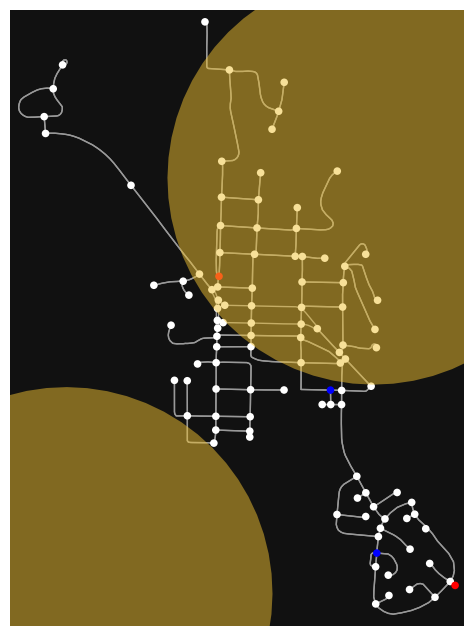

In [16]:
colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'white' for x,y in G.nodes(data=True)]
fig,ax = ox.plot_graph(G,show = False, close = False,node_size = 30, node_color = colors)

if fire_poly_mat[-1].geom_type == 'Polygon':
    x,y = fire_poly_mat[-1].exterior.xy
    ax.fill(x,y,'#f1c232ff', alpha = 0.5)
else:
    for geom in fire_poly_mat[-1].geoms:  
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='#f1c232ff', ec='none')

plt.show()

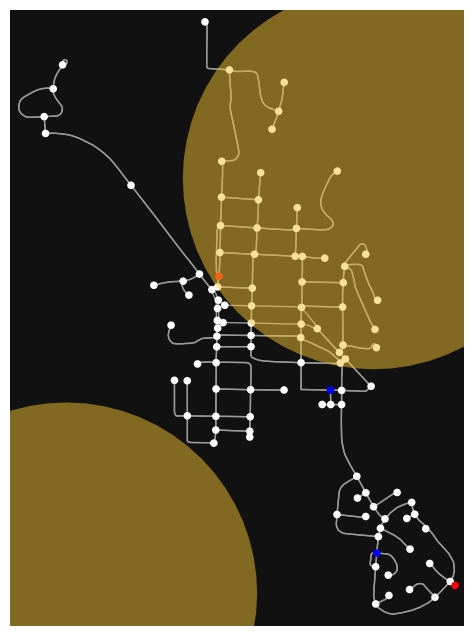

In [17]:
colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'white' for x,y in G.nodes(data=True)]
fig,ax = ox.plot_graph(G,show = False, close = False,node_size = 30, node_color = colors)

if fire_poly_mat[0].geom_type == 'Polygon':
    x,y = fire_poly_mat[0].exterior.xy
    ax.fill(x,y,'#f1c232ff', alpha = 0.5)
else:
    for geom in fire_poly_mat[0].geoms:  
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='#f1c232ff', ec='none')

plt.show()

Importing Network Complete
Consolidation Complete
Speed Added
Travel Time Added
Capacities Added
Supply and Demand Values Added
Time to Build Original Network:  0.4505164623260498  seconds


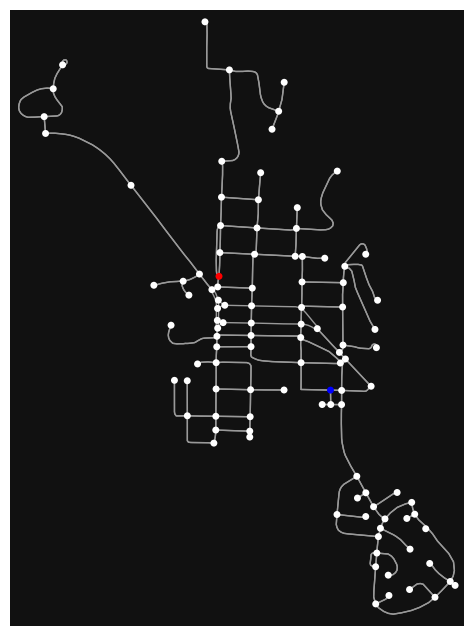

Feasability Check Completed: 0.0 seconds
Longest Path Deteremined: 0.0 seconds
Time to do Fire Poly for Time Horizon 89: 18.565027952194214
<class 'set'>
Time to build TEN for T = 89: 0.07781529426574707
Add Super Source and Sink Time:  0.1609020233154297
Time for Max Flow Algorithm 0.43643736839294434 seconds
----------------------------------------------------------------------
Construct Colored Time Expanded Model
Time to build TEN for T = 89: 0.09263753890991211
Add Super Source and Sink Time:  0.05195283889770508
Time to color edges with Flow in TEN: 0.019125938415527344
Number of Time Intervals: 89
Flow Value: 180.0


In [47]:
# fire_origin_2 = [40.229520, -105.263912]
fire_origin = [40.213739, -105.279067]
fire_radius =  0

fire_origin_radii = [(40.213739, -105.279067,0.5)]
location = 'Lyons Colorado'
sup_dem_nodes_2 = [(15,180),(30,-180)]
G_2 = construct_orig_graph(location,sup_dem_nodes_2)
colors_2=['red' if y['sup_dem'] < 0 else 'blue' if y['sup_dem'] > 0 else 'white' for x,y in G_2.nodes(data=True)]
fig,ax = ox.plot_graph(G_2,show = False, close = False,node_size = 25, node_color = colors_2)
plt.show()

num_time_ints_2, max_flow_2,flow_dict_2, flow_ten_2,full_TEN_2,fire_poly_mat_2 = det_num_int(G_2,60, fire_origin_radii)
print('Number of Time Intervals:',num_time_ints_2)
print('Flow Value:', max_flow_2)

## Dual Simplex Testing

In [ ]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
import gurobipy as gp

# nodes = [1, 2, 3, 4, 5, 6]
# edges = [[1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 6], [5, 6]]
# capacities = [2,4,6,8,2,5,5,7,8]

# capacities=np.array(capacities)
# nodes=np.array(nodes)

# G = nx.DiGraph()
# G.add_nodes_from(nodes)
# G.add_edges_from(edges)

incidence_matrix = -nx.incidence_matrix(full_TEN_2, oriented=True) 

A=incidence_matrix.toarray()
b=np.zeros((np.shape(A)[1],1))

c=[]

for i in range(len(full_TEN_2.edges)):
    if edges[i][0]==1:
        c.append(1)
    else: 
        c.append(0)

c=np.array(c)        
x=capacities.transpose()
    

m=gp.model()

m.setObjective(c@x,GRB.maximize)
m.addConstr(A@x==b)
m.addConstr(x>= 0)
m.optimize()

In [ ]:
import cplex
# import lpex3

cpx = cplex.Cplex()
cpx.read('Insert LP file here')  
# use the dual simplex   
cpx.parameters.lpmethod.set(cpx.parameters.lpmethod.values.dual)
cpx.solve()


In [ ]:
A  = nx.incidence_matrix(full_TEN, nodelist=None, edgelist=None, oriented=True, weight=None, dtype=None)

In [ ]:
num_rows, num_cols = A.shape

In [ ]:
B_u = np.identity(num_cols)
print(B_u.shape)
B_0 = -1*np.identity(num_cols)
print(B_0.shape)
B = np.concatenate([B_u,B_0], axis = 0)
print(B.shape)

# a = [[1,2,3],[4,5,6]]
# b = [[7,8,9],[10,11,12],[13,14,15]]
# ab = np.concatenate([a,b], axis = 0)
# ab

In [ ]:
edges = full_TEN.edges
# for (i,j) in edges:
#     if i == 0:
#         print('source')
caps = dict(zip(edges,[full_TEN[x][y]['upper'] for x,y in full_TEN.edges]))


In [ ]:
# caps
# edges

In [ ]:
import pyomo.environ as pyo
solvername = 'glpk'
solverpath_exe = 'C:\\Users\\DillW\\winglpk-4.65\\glpk-4.65\\w64\\glpsol'

model = pyo.ConcreteModel()

# ARCS = range(0,len(edges))
NODES = range(0,max(full_TEN.nodes))
ORIG_NODES = range(1,max(full_TEN.nodes)-1)

model.x = pyo.Var(NODES, NODES, domain = pyo.NonNegativeReals)

def up_cap_con(model,i):
    return sum(model.x[i,j]  for j in NODES if (i,j) in edges) <= caps[i]

def low_cap_con(model,i):
    return sum(model.x[i,j] for j in NODES if (i,j) in edges) >= 0

def fb_con(model,i):
    return sum(model.x[j,i] for j in NODES if (j,i) in edges) - sum(model.x[i,j] for j in NODES if (i,j) in edges) == 0

def obj_rule(model):
    return sum(model.x[0,j] for j in NODES if (0,j) in edges)

model.obj = pyo.Objective(rule = obj_rule, sense = pyo.maximize)
model.up_cap = pyo.Constraint(NODES,rule = up_cap_con)
model.low_cap = pyo.Constraint(NODES,rule = low_cap_con)
model.flow = pyo.Constraint(ORIG_NODES,rule = fb_con)
# model.color = pyo.Constraint(NODES,rule = cap_con)
# model.slot = pyo.Constraint(NODES,rule = slot_con)

result = pyo.SolverFactory(solvername,executable=solverpath_exe).solve(model)

## Testing Dynamic Updating of TEN

In [ ]:
test_copies = 3
test_time_int = 1
# test_ten = time_expand_with_removal_dyn(toy_net,nx.DiGraph(),test_time_int,0,test_copies,[[],[],[1]],[[],[(2,3)],[]])
test_ten = time_expand_with_removal_dyn(toy_net,nx.DiGraph(),test_time_int,0,test_copies)
pos = nx.multipartite_layout(test_ten, subset_key="level")
# nx.draw(test_ten, pos, with_labels=True)

In [ ]:
test_copies = 4
test_time_int = 1
# test_ten_2 = time_expand_with_removal_dyn(toy_net,test_ten,test_time_int,3,test_copies,[[],[],[1],[1,2]],[[],[(2,3)],[(2,3),(1,3)],[]])
test_ten_2 = time_expand_with_removal_dyn(toy_net,test_ten,test_time_int,3,test_copies)
pos = nx.multipartite_layout(test_ten_2, subset_key="level")
# nx.draw(test_ten_2, pos, with_labels=True)

# Code for Reconsructing Flow Paths in Original Network (Still Under Construction)

## Toy Network Things

In [ ]:
toy_net = nx.DiGraph()
toy_net.add_nodes_from(range(4))
toy_net.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)], cost = 0)
toy_net[0][1]['travel_time'] = 4
toy_net[0][2]['travel_time'] = 2
toy_net[1][2]['travel_time'] = 3
toy_net[1][3]['travel_time'] = 1
toy_net[2][3]['travel_time'] = 1
toy_net[0][1]['upper'] = 3
toy_net[0][2]['upper'] = 4
toy_net[1][2]['upper'] = 3
toy_net[1][3]['upper'] = 2
toy_net[2][3]['upper'] = 4
toy_net.nodes[0]['sup_dem'] = 9
toy_net.nodes[1]['sup_dem'] = 0
toy_net.nodes[2]['sup_dem'] = 0
toy_net.nodes[3]['sup_dem'] = -9

In [ ]:
test_copies = 6
test_time_int = 1
# test_ten = time_expand_with_removal_dyn(toy_net,nx.DiGraph(),test_time_int,0,test_copies,[[],[],[1]],[[],[(2,3)],[]])
test_ten = time_expand_with_removal_dyn(toy_net,nx.DiGraph(),test_time_int,0,test_copies)

s_t_ten = add_s_t(toy_net, test_ten, test_copies)

flow_value, flow_dict = nx.maximum_flow(s_t_ten.copy(), 0, max(list(s_t_ten.copy().nodes)),capacity = 'upper',flow_func = shortest_augmenting_path)

###code used for plotting colored max-flow on TEN
colored_max_flow_ten = color_max_flow(s_t_ten,flow_dict)
num_nodes = max(list(colored_max_flow_ten))
pos = nx.multipartite_layout(test_ten, subset_key="level")
pos[0]= np.array([pos[1][0]-0.5,pos[1][1]])
pos[max(s_t_ten.nodes)] = np.array([pos[max(test_ten.nodes)-1][0]+0.5,pos[max(test_ten.nodes)-1][1]])
colors = [colored_max_flow_ten[u][v]['color'] for u,v in colored_max_flow_ten.edges]
nx.draw(colored_max_flow_ten, pos, edge_color=colors,with_labels = True)



# pos = nx.multipartite_layout(test_ten, subset_key="level")
# nx.draw(test_ten, pos, with_labels=True)

In [ ]:
# for G in graphs:
#     colors = [G[u][v]['color'] for u,v in G.edges]
#     nx.draw(G, edge_color=colors, with_labels = True)
#     plt.show()

## Original Path Costruction Functions

In [18]:
def graph_path_color(graph, paths):
    graphs = []
    for path in paths:
        for (i,j) in graph.edges:
            graph[i][j]['color'] = (0,0,0)
        for k in range(len(path)-1):
            graph[path[k]][path[k+1]]['color'] = (1,0,0)
        graphs.append(graph.copy())
    
    return graphs

In [19]:
def ten_to_orig_paths(flow_ten, ten, G):
    ###get all edges with flow
    uni_source = min(flow_ten.nodes)
    uni_sink = max(flow_ten.nodes)
    edges_w_flow = [(x[0],x[1]) for x in flow_ten.edges(data = True) if flow_ten[x[0]][x[1]]['color'] == (1,0,0)]
    edges_w_flow.sort(key=lambda tup: tup[0])
    
    ###create link of sources and sinks
    starts = [edge[1] for edge in edges_w_flow if edge[0]==uni_source]
    ends = [edge[0] for edge in edges_w_flow if edge[1]==uni_sink]

    ###get all valid paths from sources to sinks using arcs wtih flow
    valid_paths = []
    for source in starts:
        paths = find_all_paths(edges_w_flow, source, ends, path=[])
        for path in paths:
            if nx.is_path(ten, path) and path not in valid_paths:
                # print(path)
                valid_paths.append(path)
    # print(valid_paths)

    ###convert from TEN paths to original network paths
    orig_paths = orig_graph_path(ten, valid_paths, [uni_source, uni_sink])

    return orig_paths

In [20]:
###Dijkstra's algorithm (with some modifications)
def find_all_paths(edge_list, start, ends, path=[]):
        # print(start)
        path = path + [start]
        if start in ends:
            return [path]
        if start not in [edge[0] for edge in edge_list]:
            return []
        paths = []
        for node in [edge[0] for edge in edge_list]:
            if node not in path and node in [edge[1] for edge in edge_list if edge[0] == start]:
                newpaths = find_all_paths(edge_list, node, ends, path)
                for newpath in newpaths:
                    paths.append(newpath)
        return paths

In [41]:
def remove_dups(path):
    remove = []
    path_copy = []
    for i in range(len(path)-1):
        if path[i] == path[i+1]:
            remove.append(i)

    for i in range(len(path)-1):
        if i not in remove:
            path_copy.append(path[i])
    # seen = set()
    # seen_add = seen.add
    # return [x for x in seq if not (x in seen or seen_add(x))]
    return path_copy

In [30]:
def orig_graph_path(ten, paths, endpoints):
    orig_paths = []
    for path in paths:
        orig_path = []
        for node in path:
            nodes = [y['name'] for x,y in ten.nodes(data=True) if x == node]
            # print(nodes)
            node_str = nodes[0].split('-')
            orig_node = node_str[0]
            orig_path.append(int(orig_node)-1)
        orig_paths.append(remove_dups(orig_path))
        # orig_paths.append(orig_path)
    return orig_paths

## Testing Real-worl Example

In [ ]:
# print(full_TEN)

In [49]:
# orig_paths = ten_to_orig_paths(colored_max_flow_ten,test_ten, toy_net)
orig_paths = ten_to_orig_paths(flow_ten,full_TEN, G)

In [43]:
orig_paths

[[1, 0, 4, 77, 4, 77, 4, 77, 62],
 [1, 0, 4, 77, 4, 77, 4, 77, 62],
 [1, 0, 4, 77, 4, 77, 4, 77, 62]]

In [26]:
# colors_2=['red' if x in orig_paths[4] else 'white' for x,y in G.nodes(data=True)]
# fig,ax = ox.plot_graph(G,show = False, close = False,node_size = 25, node_color = colors_2)

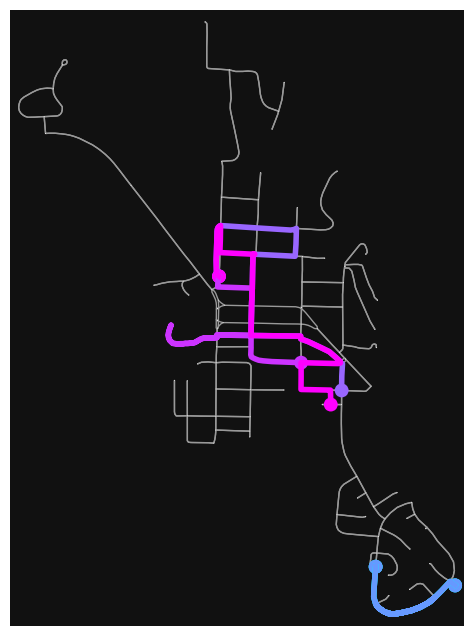

In [50]:
# fig, ax = ox.plot_graph_route(G, orig_paths[4], route_color='y', route_linewidth=6, node_size=2, show = False, close = False)

cl = np.array(ox.plot.get_colors(len(orig_paths),cmap = "cool",return_hex = True))
fig, ax = ox.plot_graph_routes(G, orig_paths, route_colors=cl, route_linewidth=3, node_size=0.5, show = False, close = False, route_alpha = 1)

## Testing Garbage

In [ ]:
edges_w_flow = [(x[0],x[1]) for x in colored_max_flow_ten.edges(data = True) if colored_max_flow_ten[x[0]][x[1]]['color'] == (1,0,0)]
edges_w_flow.sort(key=lambda tup: tup[0])

start = min(colored_max_flow_ten.nodes)
end = max(colored_max_flow_ten.nodes)
starts = [edge[1] for edge in edges_w_flow if edge[0]==start]
ends = [edge[0] for edge in edges_w_flow if edge[1]==end]

In [ ]:
edges_w_flow

In [ ]:
all_paths = []
for start in starts:
    paths = find_all_paths(edges_w_flow, start, ends, path=[])
    all_paths.append(paths)

In [ ]:
all_paths

In [ ]:
valid_paths = []
for path in paths:
    if nx.is_path(test_ten, path) and path not in valid_paths:
        valid_paths.append(path)

In [ ]:
valid_paths

In [ ]:
valid_orig_paths = orig_graph_path(test_ten, valid_paths, [start, end])
# for path in valid_orig_paths:
#     if nx.is_path(G, path):
#         print(path)
#         print('valid path')

In [ ]:
valid_orig_paths

In [ ]:
cl = np.array(ox.plot.get_colors(len(valid_orig_paths),cmap = "cool",return_hex = True))
fig, ax = ox.plot_graph_routes(G, valid_orig_paths, route_colors=cl, route_linewidth=3, node_size=0.5, show = False, close = False, route_alpha = 1)